## Nuclear Masses

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd
import emcee
from tqdm import tqdm
import corner


### Bayesian Inference

In [2]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

In [3]:
def model(a_v,a_s,a_c,a_a, a_p,N,Z):
    A = N + Z
    #Coulomb can be Z*(Z-1) or Z**2
    ret = (a_v*A - a_s*A**(2/3) - a_c*(Z**2)/(A**(1/3)) - a_a*((N-Z)**2)/A)
    addend = (a_p*A**(-3/4))
    ret += np.logical_and((N%2 == 0), (Z%2 == 0)) * addend
    ret -= np.logical_and((N%2 == 1), (Z%2 == 1)) * addend
    return ret/A

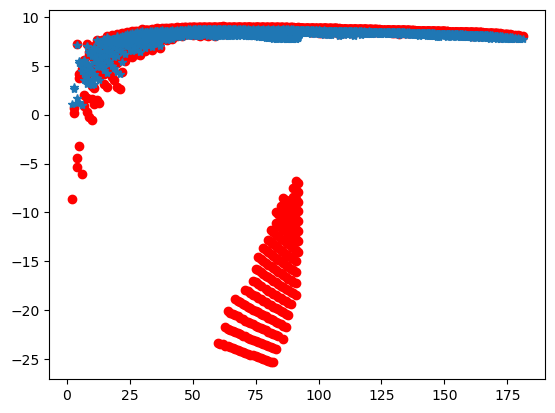

In [4]:
n_points = 2000
A = N +Z
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_th = 16
a_s_th = 18
a_c_th = 0.7
a_a_th = 24
a_p_th = 34

BE_th = model(a_v_th, a_s_th, a_c_th, a_a_th, a_p_th, N, Z)
plt.scatter(A[:n_points], BE_th[:n_points], color = 'red')

In [5]:
print(A[1500:n_points], BE_th)

[152 152 152 152 152 152 152 153 153 153 153 153 153 153 153 153 153 153
 153 154 154 154 154 154 154 154 154 154 154 154 154 155 155 155 155 155
 155 155 155 155 155 155 155 155 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 157 157 157 157 157 157 157 157 157 157 157 157 157 157
 158 158 158 158 158 158 158 158 158 158 158 158 158 159 159 159 159 159
 159 159 159 159 159 159 159 159 159  60 160 160 160 160 160 160 160 160
 160 160 160 160 160 160  61 161 161 161 161 161 161 161 161 161 161 161
 161 161  62 162 162 162 162 162 162 162 162 162 162 162 162  63  63 163
 163 163 163 163 163 163 163 163 163 163 163  64  64  64 164 164 164 164
 164 164 164 164 164 164 164 164  65  65  65 165 165 165 165 165 165 165
 165 165 165  66  66  66 166 166 166 166 166 166 166 166 166 166  67  67
  67  67 167 167 167 167 167 167 167 167 167  68  68  68  68 168 168 168
 168 168 168 168 168 168 168  69  69  69  69 169 169 169 169 169 169 169
 169  70  70  70  70 170 170 170 170 170 170 170  7

## EMCEE

In [6]:
# Parameters
param_names = ['a_v', 'a_s', 'a_c', 'a_a', 'a_p']

def loglikelihood(params):
    (a_v, a_s, a_c, a_a, a_p) = params
    log_like = -np.sum(((model(a_v, a_s, a_c, a_a, a_p, N, Z) - BE)/BE_err)**2 + np.log(2*np.pi*BE_err**2)) / 2. 
    return log_like
    
def prior(params):
    (a_v, a_s, a_c, a_a, a_p) = params

    if (
        0 < a_v < 50 and
        0 < a_s < 50 and
        0 < a_c < 3 and
        -40 < a_a < 40 and
        -50 < a_p < 50
    ):
        return 0

    return -np.inf

def log_post(params):
    if not np.isfinite(prior(params)):
        return -np.inf
    return loglikelihood(params) + prior(params)

In [7]:
ndim = 5
nwalkers = 30

p0 = np.array([0, 0, 0, 0, 0]) + np.random.rand(nwalkers, ndim) * np.array(
    [50, 50, 3, 40, 50]
)

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=())
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [02:32<00:00, 65.53it/s]


State([[12.17240473 11.31612     0.21537281 -2.1755119   8.31407179]
 [12.17240489 11.31612033  0.21537284 -2.17551243  8.31407098]
 [12.17240466 11.31611975  0.21537278 -2.1755115   8.31407191]
 [12.17240468 11.31611993  0.21537279 -2.1755116   8.31406999]
 [12.17240481 11.31612014  0.21537283 -2.17551225  8.31407162]
 [12.17240476 11.31612021  0.21537278 -2.17551131  8.31407146]
 [12.17240476 11.31611996  0.2153728  -2.17551172  8.31407126]
 [12.17240496 11.31612043  0.21537283 -2.17551225  8.31407112]
 [12.17240441 11.31611953  0.21537273 -2.17551093  8.31407026]
 [12.17240481 11.31612017  0.21537282 -2.17551208  8.31407059]
 [12.17240506 11.31612049  0.21537285 -2.17551256  8.31407025]
 [12.17240512 11.31612056  0.21537288 -2.17551302  8.31407061]
 [12.17240473 11.31611986  0.21537281 -2.17551181  8.31407087]
 [12.1724049  11.31612027  0.21537282 -2.17551202  8.31406877]
 [12.17240459 11.31611987  0.21537277 -2.17551164  8.31407061]
 [12.17240496 11.31612063  0.21537282 -2.17551187

Text(0.5, 0, 'step number')

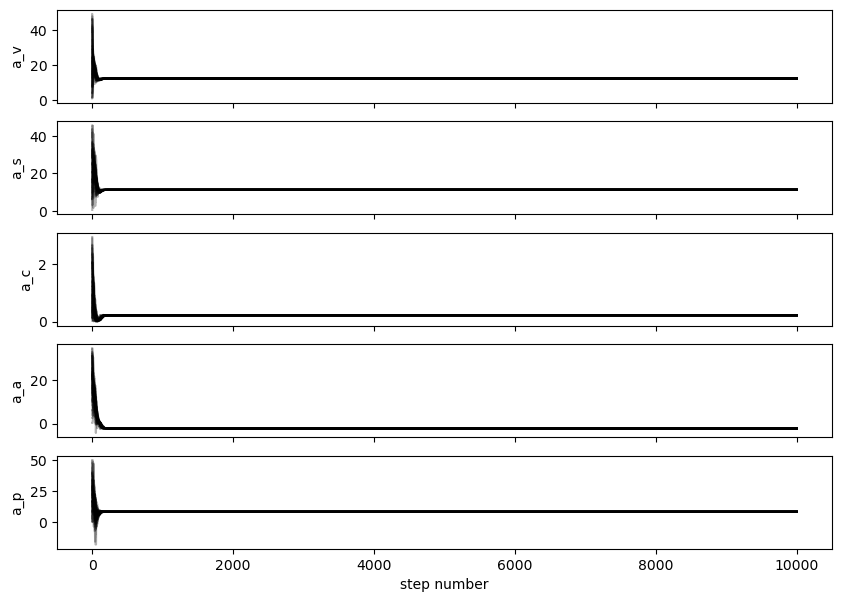

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for index, ax in enumerate(axs):
    ax.plot(samples[:, :, index], "k", alpha=0.3)
    ax.set_ylabel(["a_v", "a_s", "a_c", "a_a", "a_p"][index])

axs[-1].set_xlabel("step number")

Quantiles:
[(0.025, np.float64(12.172404231342911)), (0.5, np.float64(12.172404769254328)), (0.975, np.float64(12.172405315641678))]
Quantiles:
[(0.025, np.float64(11.316119100803276)), (0.5, np.float64(11.316120069043459)), (0.975, np.float64(11.316121060707307))]
Quantiles:
[(0.025, np.float64(0.21537270914912215)), (0.5, np.float64(0.2153728040951815)), (0.975, np.float64(0.21537289882145563))]
Quantiles:
[(0.025, np.float64(-2.175513311420406)), (0.5, np.float64(-2.1755118620509584)), (0.975, np.float64(-2.175510411814454))]
Quantiles:
[(0.025, np.float64(8.314069759893561)), (0.5, np.float64(8.314071246684545)), (0.975, np.float64(8.314072707570764))]


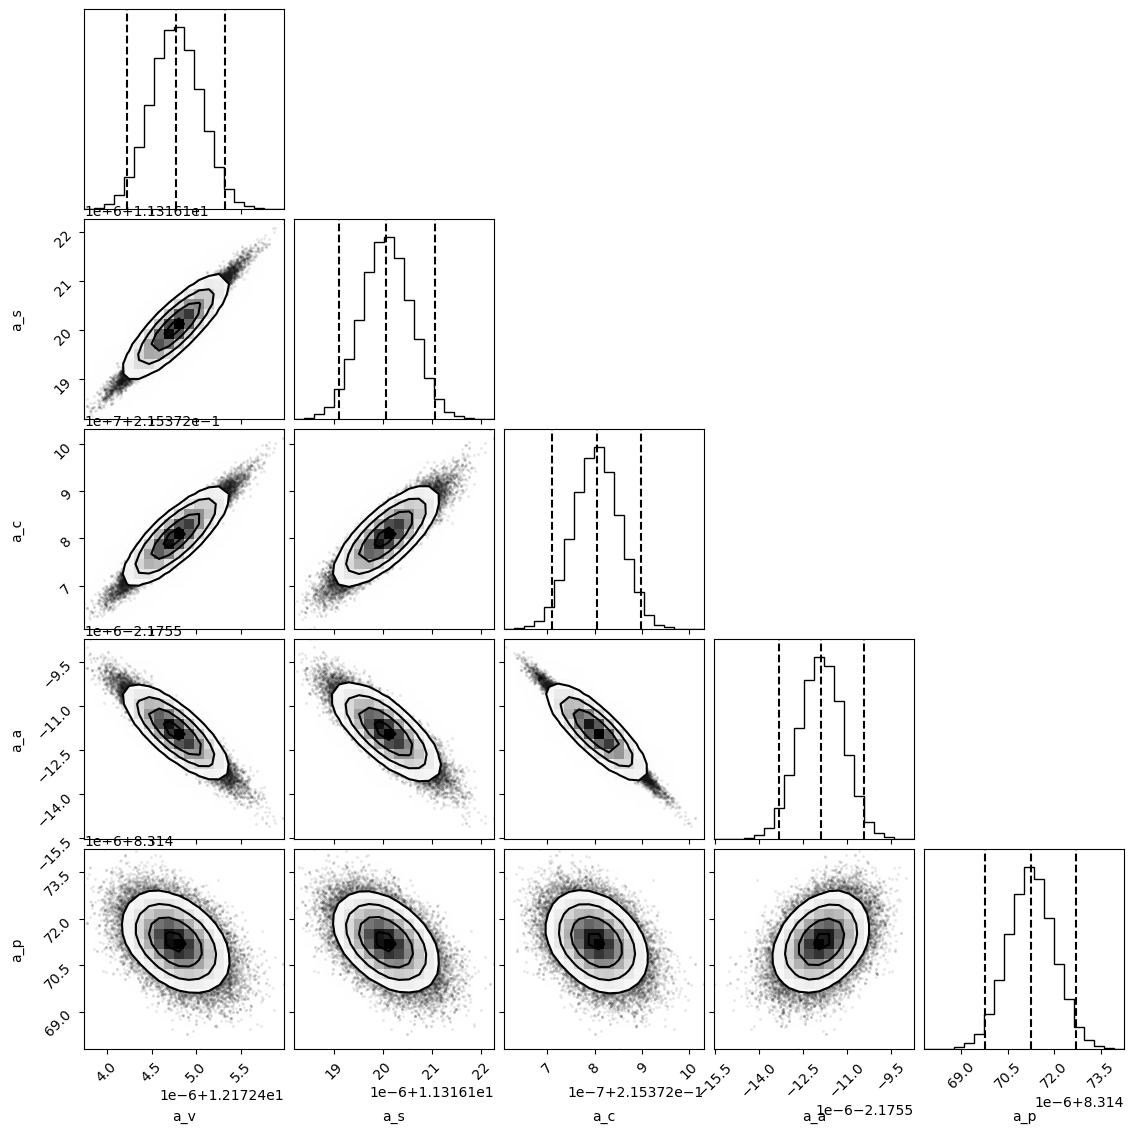

In [10]:
flat_samples = sampler.get_chain(discard=5000, thin=3, flat=True)
fig = corner.corner(flat_samples, labels=["a_v", "a_s", "a_c", "a_a", "a_p"], verbose= True, plot_contours=True, quantiles=[0.025, 0.5, 0.975], smooth=True)

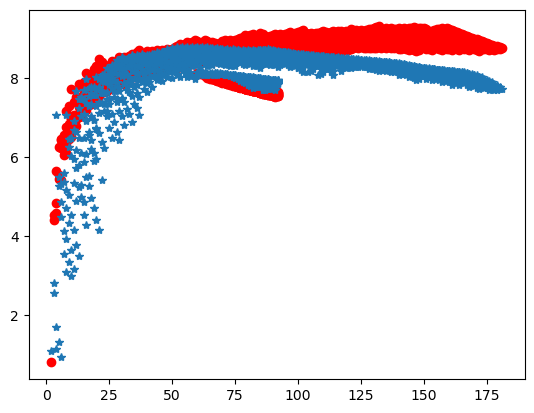

In [11]:
A = N + Z
n_points = 2000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_best = 12
a_s_best = 11
a_c_best = 0.2
a_a_best = -2
a_p_best = 8

BE_best = model(a_v_best, a_s_best, a_c_best, a_a_best, a_p_best, N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red')